In [2]:
import numpy as np
import scipy.sparse as sp
import os
import subprocess
import csv

import matplotlib.pyplot as plt
from clusim.clustering import Clustering
import clusim.sim as sim
import clusim.clugen as clugen
import clusim.clusimelement as elsim
from tqdm import tqdm

from fstar import *

In [4]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Set up

First, you must install clusim directly from source. Clusim is available on via pypi but is missing a critical patch that will cause this notebook to fail.
```{zsh}
git clone https://github.com/Hoosier-Clusters/clusim.git
cd clusim
pip install .
```

Next, you must install and make the oNMI code from https://github.com/aaronmcdaid/Overlapping-NMI and set the following variable to the path to the executable.

Finally, make sure this package is installed, which can be acheived by running ```pip install .``` from the main directory.

In [5]:
## overlapping NMI executable
oNMI_path = '../../Overlapping-NMI/onmi'

In [6]:
# Global test params
n_samples = 25
n_elements = 1024
n_clusterfixed = 32


measure_list = ['omega_index', 'onmi', 'oNMI', 'elmsim', "fstar"]
measure_name = ['Omega', r'$\mathrm{oNMI_{LFK}}$', r'$\mathrm{oNMI_{MGH}}$', 'ECC', r"$\mathrm{F^*_{wo}}$"]
n_measures = len(measure_list)

def hex2rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16)/255. for i in range(0, lv, lv // 3))


def set_size(w,h, ax=None):
    """ w, h: width, height in cm """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)/2.54 #2.54 cm per inch
    figh = float(h)/(t-b)/2.54 
    ax.figure.set_size_inches(figw, figh)

BiasColorDict = {}
BiasColorDict['omega_index'] = hex2rgb("#59a89c")
BiasColorDict['onmi'] = hex2rgb("#f0c571")
BiasColorDict['oNMI'] = hex2rgb('#C86629')
BiasColorDict['elmsim'] = hex2rgb("#082a54")
BiasColorDict['fstar'] = hex2rgb("#e02b35")

In [3]:
## Helper functions for massaging input type

def sparse_to_clustering(sparse):
    cluster_list = list(sparse.tolil().rows)
    # outlier_ids = np.arange(sparse.shape[1])[sparse.getnnz(0) == 0]
    # for outlier_id in outlier_ids:
    #     cluster_list.append([outlier_id])
    return Clustering().from_cluster_list(cluster_list) 


def clustering_to_sparse(clustering):
    clu2elm = clustering.to_clu2elm_dict()
    n_elem = len(clustering.to_elm2clu_dict())
    sparse = sp.lil_matrix((len(clu2elm), n_elem), dtype="bool")
    for clu, elms in clu2elm.items():
        elms = list(elms)
        sparse[clu, elms] = True
    return sparse.tocsr()


In [4]:
def oNMI(c1, c2):
    if isinstance(c1, np.ndarray):
        c1 = clustering_array_to_sparse(c1)
    elif isinstance(c1, Clustering):
        c1 = clustering_to_sparse(c1)
    if isinstance(c2, np.ndarray):
        c2 = clustering_array_to_sparse(c2)
    elif isinstance(c2, Clustering):
        c2 = clustering_to_sparse(c2)

    # Convert clusterings to a list of lists
    c1 = list(c1.tolil().rows)
    with open("c1.csv", "w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(c1)
    f.close()
    c2 = list(c2.tolil().rows)
    with open("c2.csv", "w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(c2)
    f.close()
    x = float(subprocess.check_output([oNMI_path,"c1.csv","c2.csv"]).decode("utf-8").split()[1])
    _ = os.system('rm c1.csv')
    _ = os.system('rm c2.csv')
    return x

In [5]:
def elmsim(c1, c2):
    # set paramter values for element_centric similarity
    return np.mean(sim.element_sim_elscore(c1, c2, alpha = 0.9, differing_elements="isolated")[0])

# Example 1

In [7]:
n_shuffle_points = 40

percent_shuffle_values = np.linspace(0.0, 1.0, n_shuffle_points)
percent_randomize_compare = np.zeros((n_measures, n_shuffle_points, n_samples))

In [8]:
np.random.seed(42)
with tqdm(total=n_samples*n_shuffle_points) as pbar:
    for isample in range(n_samples):            
        # loop through the shuffle fraction points
        for iper in range(n_shuffle_points):
            random_cluster = clugen.make_equal_clustering(n_elements, n_clusterfixed)
            random_cluster2 = clugen.shuffle_memberships(random_cluster, percent = percent_shuffle_values[iper])
            for imeasure in range(n_measures):
                if measure_list[imeasure] in ['oNMI', "fstar"]:
                    c1 = clustering_to_sparse(random_cluster)
                    c2 = clustering_to_sparse(random_cluster2)
                    percent_randomize_compare[imeasure, iper, isample] = eval(measure_list[imeasure]+'(c1, c2)')
                elif measure_list[imeasure] in ['elmsim']:
                    percent_randomize_compare[imeasure, iper, isample] = eval(measure_list[imeasure]+'(random_cluster, random_cluster2)')
                else:
                    percent_randomize_compare[imeasure, iper, isample] = eval('sim.'+measure_list[imeasure]+'(random_cluster, random_cluster2)')
            pbar.update()

measure_means = np.mean(percent_randomize_compare, axis = 2)
measure_stds = np.std(percent_randomize_compare, axis = 2)

np.save("random_means.npy", measure_means)
np.save("random_stds.npy", measure_stds)
print("Simulation Finished")

  1%|          | 8/1000 [00:00<01:23, 11.82it/s]


KeyboardInterrupt: 

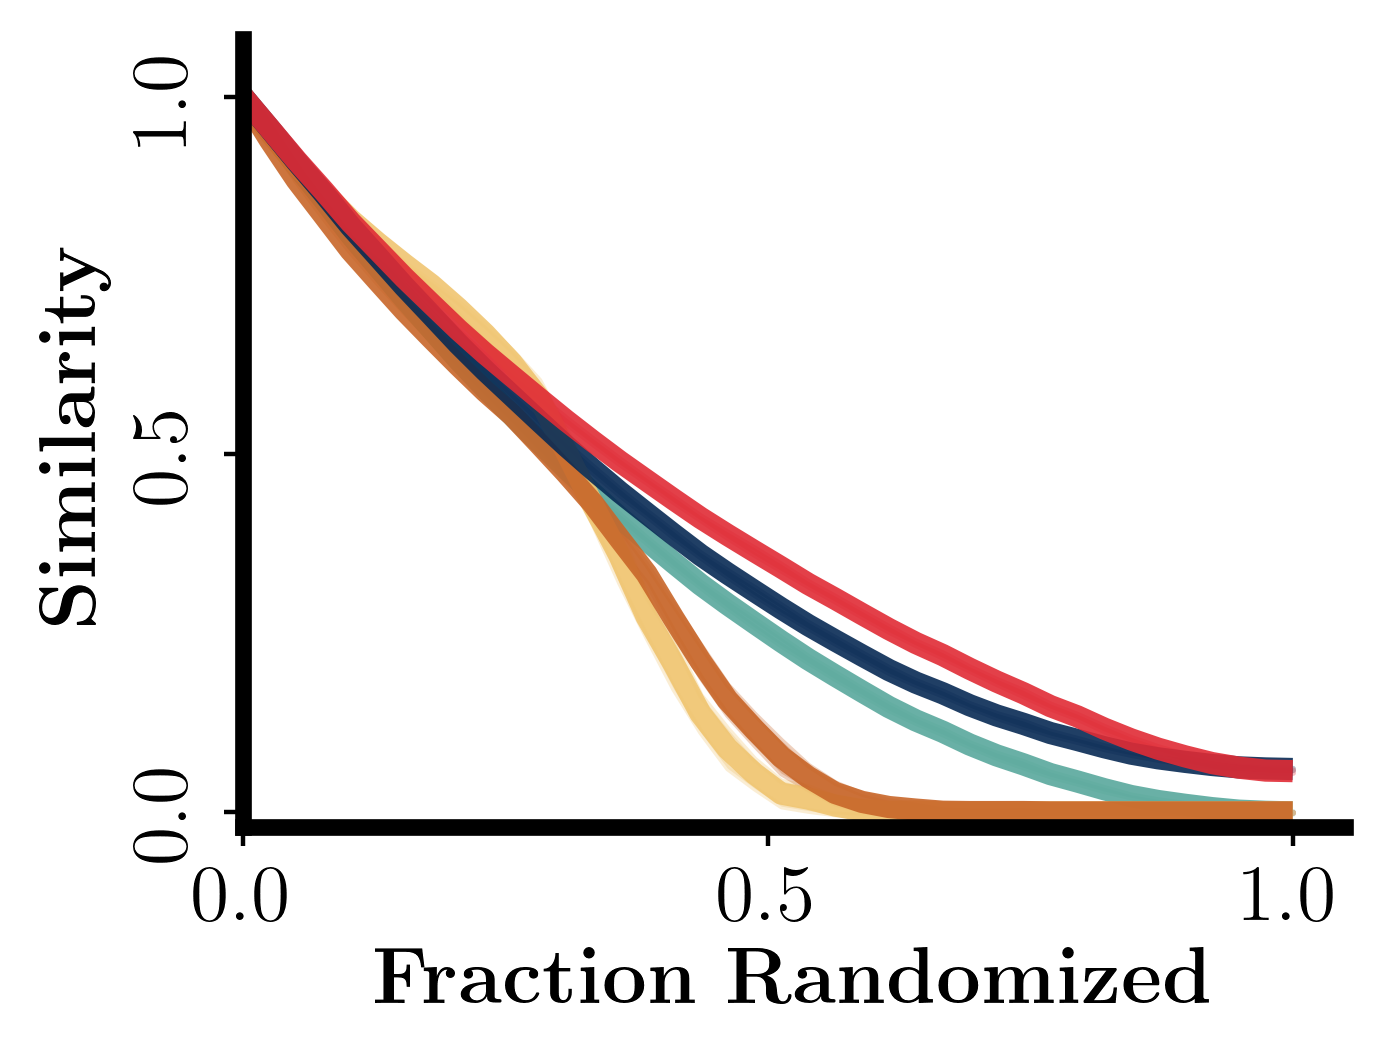

In [121]:
# plot results
measure_means = np.load("random_means.npy")
measure_stds = np.load("random_stds.npy")

fig, ax = plt.subplots(dpi=400)

for imeasure in range(n_measures):
    line = ax.plot(percent_shuffle_values, measure_means[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 4, dashes = [500,1])
    
for imeasure in range(n_measures):
    ax.fill_between(percent_shuffle_values, measure_means[imeasure] - measure_stds[imeasure], 
                measure_means[imeasure] + measure_stds[imeasure], 
                        color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)

ax.set_xlim([0,1.05])
ax.set_ylim([-0.02, 1.08])
ax.set_xticks([0.0, 0.5, 1.0])
ax.set_yticks([0.0, 0.5, 1.0])
plt.yticks(rotation=90, va="center")
ax.tick_params(labelsize=14.4)

ax.set_xlabel(r'\Large\bf Fraction Randomized')
ax.set_ylabel(r'\Large \bf Similarity')

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(3)

#ax.legend(labels=measure_name)
set_size(7,5)
plt.show()

# Example 2

In [40]:
n_skew_points = 10**2 # increase to 10**4 to increase the entropy range as in the paper
skew_step_size = 5*10**2
n_bins = 40

In [49]:
%%time
np.random.seed(42)
skewed_clusters_compare = np.zeros((n_measures + 1, n_skew_points, n_samples)) # we also need to store the cluster entropy
initial_cluster = clugen.make_equal_clustering(n_elements, n_clusterfixed)

with tqdm(total=n_samples*n_skew_points) as pbar:
    for isample in range(n_samples):
        # create a copy of the original clustering with all memberships randomized
        random_cluster = clugen.shuffle_memberships(initial_cluster, percent = 1.0)
        # loop through the fraction points
        for istep in range(n_skew_points):        
            # record the entropy
            skewed_clusters_compare[n_measures, istep, isample] = sim.entropy(np.array(random_cluster.clu_size_seq, dtype = float)/n_elements)
            # perform clustering similarity measurements
            for imeasure in range(n_measures):
                if measure_list[imeasure] in ['oNMI', "fstar"]:
                    c1 = clustering_to_sparse(initial_cluster)
                    c2 = clustering_to_sparse(random_cluster)
                    skewed_clusters_compare[imeasure, istep, isample] = eval(measure_list[imeasure]+'(c1, c2)')
                elif measure_list[imeasure] in ['elmsim']:
                    skewed_clusters_compare[imeasure, istep, isample] = eval(measure_list[imeasure]+'(initial_cluster, random_cluster)')
                else:
                    skewed_clusters_compare[imeasure, istep, isample] = eval('sim.'+measure_list[imeasure]+'(initial_cluster, random_cluster)')
                
            # now apply the Preferential Attachment Model 'skew_step_size' times
            random_cluster = clugen.shuffle_memberships_pa(random_cluster, n_steps=skew_step_size, 
                                                        constant_num_clusters=True)
            pbar.update()

# once we have finished sampling clusterings, we need to aggregate the comparisons by cluster size entropy
n_bins = 40

def binned_index(value, bins):
    return ((value >= bins).argmin().astype(int) - 1)
binned_index = np.vectorize(binned_index, excluded=[1]) 

entropy_bins = np.linspace(skewed_clusters_compare[-1].min(), skewed_clusters_compare[-1].max(), n_bins + 1)
skewed_clusters_compare[-1] = binned_index(skewed_clusters_compare[-1], entropy_bins)

skew_measure_means = np.zeros((n_measures, n_bins))
skew_measure_stds = np.zeros((n_measures, n_bins))

for ibin in range(n_bins):
    skew_measure_means[:,ibin] = np.nanmean(skewed_clusters_compare[:-1][:, skewed_clusters_compare[-1] == ibin], axis = 1)
    skew_measure_stds[:,ibin] = np.nanstd(skewed_clusters_compare[:-1][:, skewed_clusters_compare[-1] == ibin], axis = 1)

np.save("entropy_bins.npy", entropy_bins)
np.save("skew_means.npy", skew_measure_means)
np.save("skew_stds.npy", skew_measure_stds)
print("Simulation Finished")

100%|██████████| 2500/2500 [04:11<00:00,  9.93it/s]

Simulation Finished
CPU times: user 2min 52s, sys: 48.2 s, total: 3min 40s
Wall time: 4min 11s


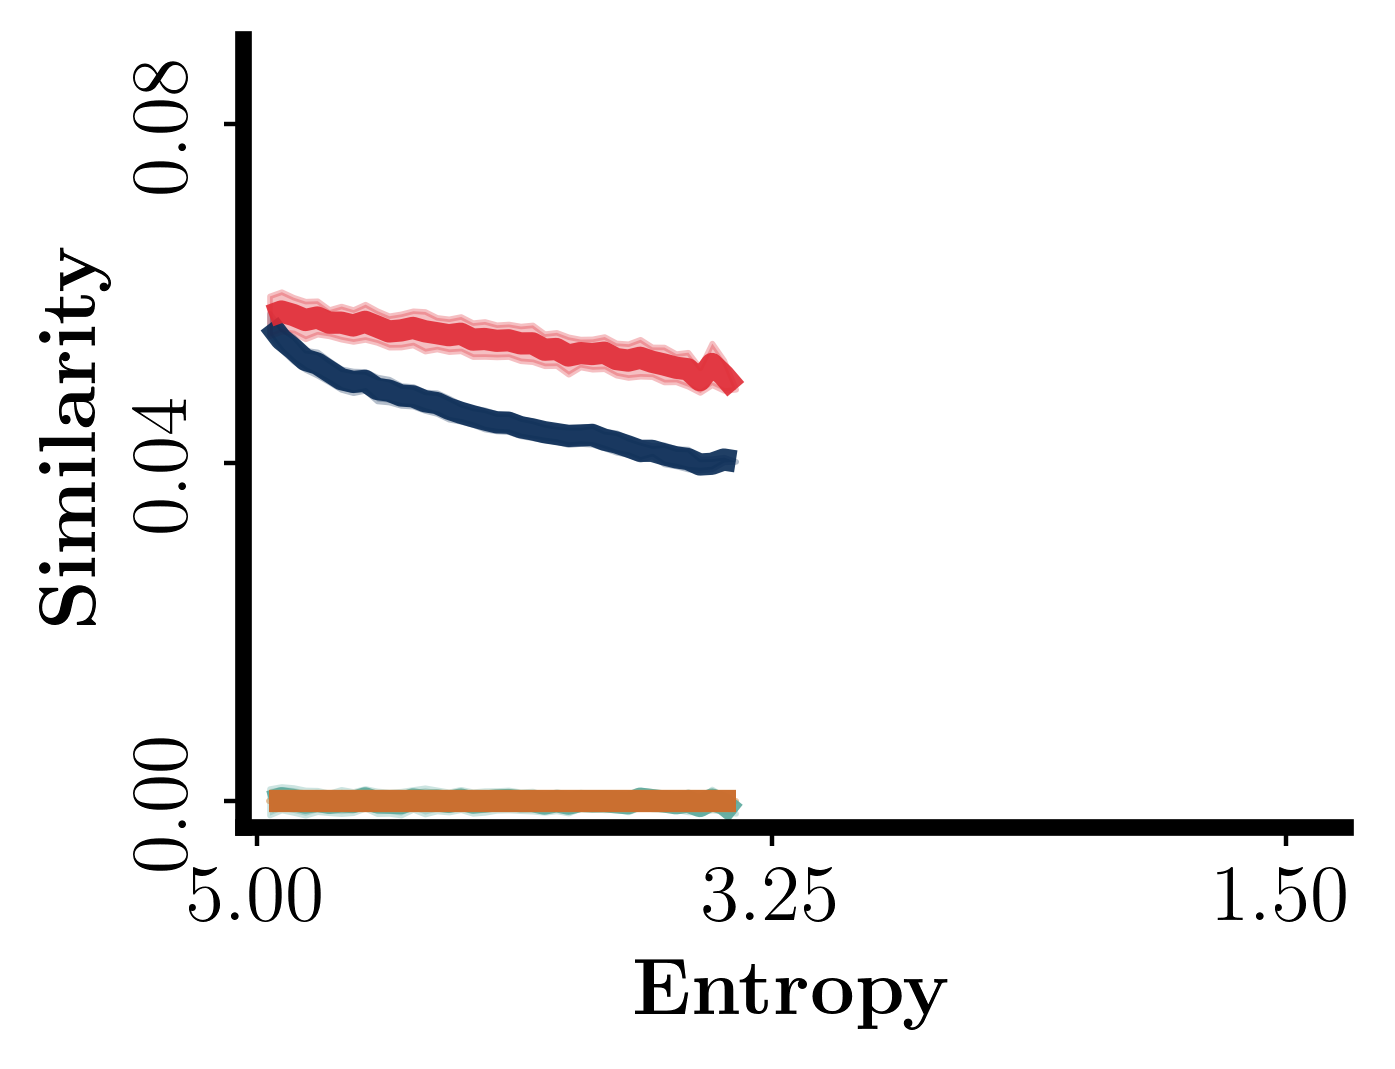

In [115]:
# plot results
entropy_bins = np.load("entropy_bins.npy")
skew_measure_means = np.load("skew_means.npy")
skew_measure_stds = np.load("skew_stds.npy")

fig, ax = plt.subplots(1,1, figsize = (6,6), dpi=400)

for imeasure in range(n_measures):
    line = ax.plot(entropy_bins[:-1], skew_measure_means[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 4, dashes = [500,1])

for imeasure in range(n_measures):
    ax.fill_between(entropy_bins[:-1], skew_measure_means[imeasure] - skew_measure_stds[imeasure], 
                    skew_measure_means[imeasure] + skew_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)

ax.set_ylim([-0.003, 0.09])
ax.set_xlim([5.05, 1.3])
ax.set_xticks([5.,3.25, 1.5])
ax.set_yticks([0,0.04, 0.08])
plt.yticks(rotation=90, va="center")
ax.tick_params(labelsize=14.4)

ax.set_xlabel(r'\Large \bf Entropy')
ax.set_ylabel(r'\Large \bf Similarity')

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(3)

#ax.legend(labels=measure_name, fontsize=20)
set_size(7,5)
#plt.tight_layout()
plt.show()

# Example 3

In [81]:
min_clusters = 2**3
n_cluster_points = 40
number_cluster_values = np.logspace(np.log2(min_clusters), np.log2(n_elements), n_cluster_points, base = 2, dtype = int)

In [11]:
np.random.seed(42)
number_cluster_compare = np.zeros((n_measures, n_cluster_points, n_samples))

with tqdm(total=n_samples*n_cluster_points) as pbar:
    for isample in range(n_samples):            
        initial_cluster = clugen.make_equal_clustering(n_elements, min_clusters)
        for ipoint in range(n_cluster_points):
            random_cluster = clugen.make_equal_clustering(n_elements, number_cluster_values[ipoint])
            random_cluster = clugen.shuffle_memberships(random_cluster, percent = 1.0)
            # perform clustering similarity measurements
            for imeasure in range(n_measures):
                if measure_list[imeasure] in ['oNMI', "fstar"]:
                    c1 = clustering_to_sparse(initial_cluster)
                    c2 = clustering_to_sparse(random_cluster)
                    number_cluster_compare[imeasure, ipoint, isample] = eval(measure_list[imeasure]+'(c1, c2)')
                elif measure_list[imeasure] in ['elmsim']:
                    number_cluster_compare[imeasure, ipoint, isample] = eval(measure_list[imeasure]+'(initial_cluster, random_cluster)')
                else:
                    number_cluster_compare[imeasure, ipoint, isample] = eval('sim.'+measure_list[imeasure]+'(initial_cluster, random_cluster)')
            pbar.update()

numc_measure_mean = np.mean(number_cluster_compare, axis = 2)
numc_measure_stds = np.std(number_cluster_compare, axis = 2)

np.save("numc_mean.npy", numc_measure_mean)
np.save("numc_std.npy", numc_measure_stds)

print("Simulation Finished")

100%|██████████| 1000/1000 [02:10<00:00,  7.67it/s]

Simulation Finished


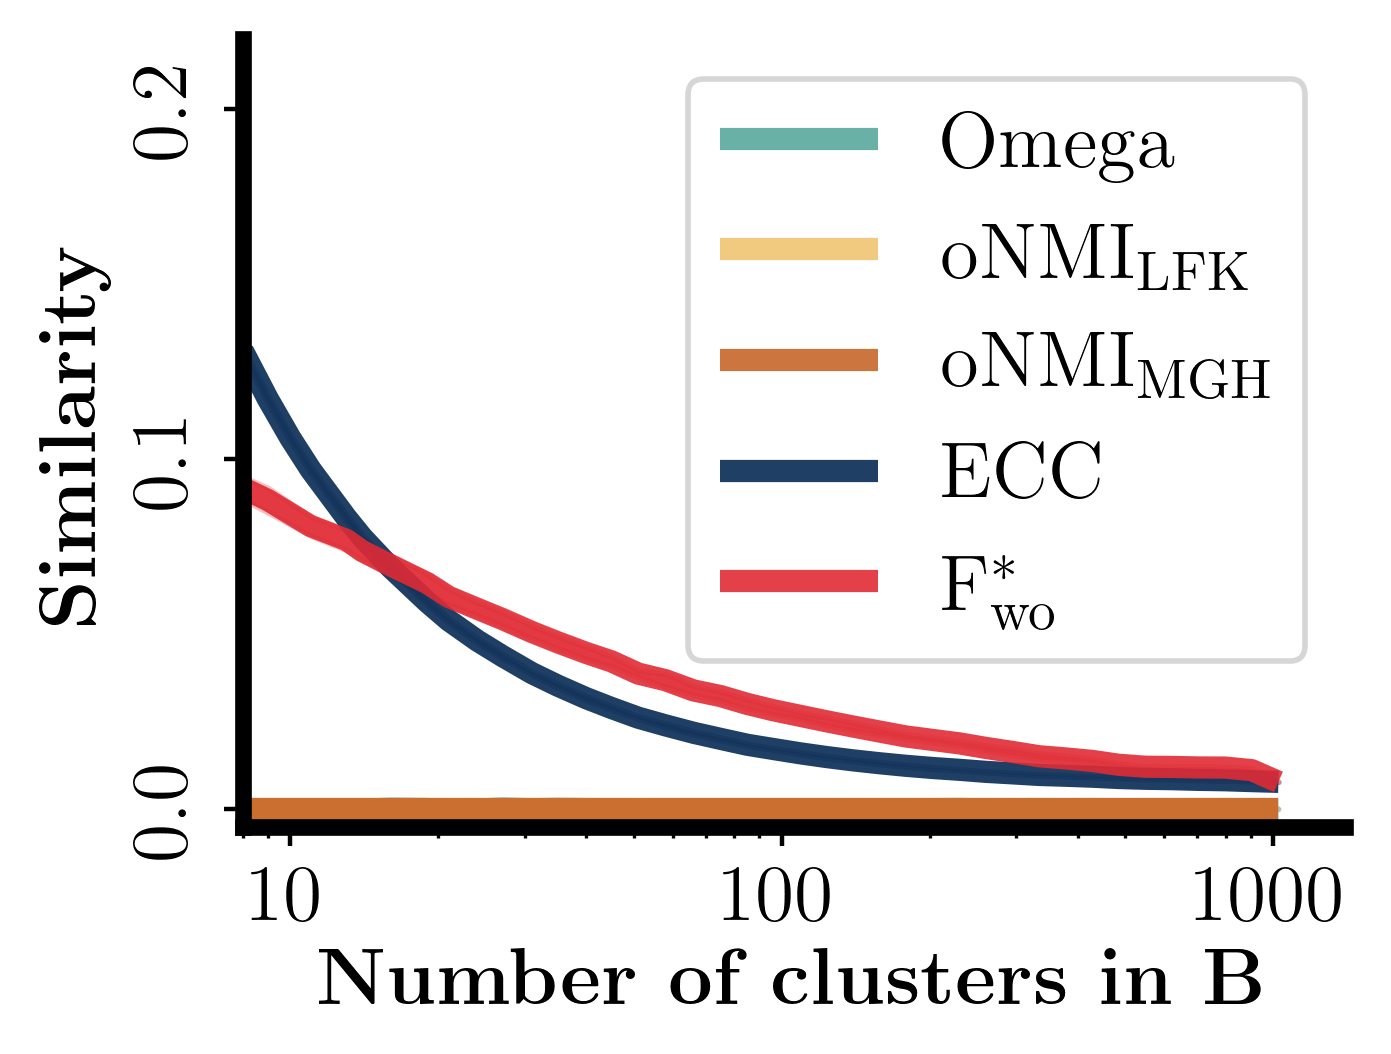

In [109]:
# plot results
numc_measure_mean = np.load("numc_mean.npy")
numc_measure_stds = np.load("numc_std.npy")

fig, ax = plt.subplots(1,1, figsize = (6,6), dpi=400)
ax.set_xscale('log')

for imeasure in range(n_measures):
    line = ax.plot(number_cluster_values, numc_measure_mean[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 4, dashes = [500,1])

for imeasure in range(n_measures):
    ax.fill_between(number_cluster_values, numc_measure_mean[imeasure] - numc_measure_stds[imeasure], 
                    numc_measure_mean[imeasure] + numc_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)

ax.set_ylim([-0.005, 0.22])
ax.set_xlim([8, 1400])
ax.set_xticks([10, 100, 1000], [10, 100, 1000])
ax.set_yticks([0.0, 0.1, 0.2])
plt.yticks(rotation=90, va="center")
ax.tick_params(labelsize=14.4)

ax.set_xlabel(r'\Large \bf Number of clusters in B')
ax.set_ylabel(r'\Large \bf Similarity')    

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(3)

ax.legend(labels=measure_name, fontsize=14.3)
set_size(7,5)
plt.show()

# Example 4

In [14]:
def sample_geom_and_primary_com(n_elements, community_sizes, rng):
    theta = rng.uniform(0,2*np.pi, n_elements)
    radius = rng.uniform(0,1, n_elements) ** 0.5
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    geom_layer = np.vstack([x,y]).T

    primary_community = np.full(geom_layer.shape[0], -1)
    for i, n in enumerate(community_sizes):
        unassigned = geom_layer[primary_community==-1, :]
        magnitudes = np.sqrt(np.sum(unassigned**2,axis=1))
        furthest_id = np.argmax(magnitudes)
        furthest = unassigned[furthest_id, :]
        dist_to_furthest = np.sqrt(np.sum((unassigned - furthest)**2, axis=1))
        primary_members = np.argsort(dist_to_furthest)[:n]
        original_indices = np.arange(geom_layer.shape[0])[primary_community==-1]
        primary_community[original_indices[primary_members]] = i
    
    return geom_layer, primary_community


def expand_communities(geom_layer, primary_community, eta):
    overlapping_coms = sp.lil_matrix((np.max(primary_community)+1, n_elements), dtype="bool")
    ids = np.arange(len(primary_community))
    for com in range(np.max(primary_community)+1):
        n_new_nodes = int(np.sum(primary_community == com) * eta) - np.sum(primary_community == com)
        center = np.mean(geom_layer[primary_community == com, :], axis=0)
        other_coms = geom_layer[primary_community != com]
        original_ids = ids[primary_community != com]
        distances_to_center = np.sqrt(np.sum((other_coms - center)**2, axis=1))
        new_ids = np.argsort(distances_to_center)[:n_new_nodes]
        new_original_ids = original_ids[new_ids]
        all_com_ids = np.union1d(ids[primary_community == com], new_original_ids)
        overlapping_coms[com, all_com_ids] = True
    return overlapping_coms.tocsr()

In [17]:
base_eta = 3
n_etas = 11
rng = np.random.default_rng(seed=42)

etas = np.linspace(1, 11, n_etas)
overlap_compare = np.zeros((n_measures, len(etas), n_samples))
community_sizes = [n_elements // n_clusterfixed] *  n_clusterfixed

with tqdm(total=len(etas)*n_samples) as pbar:
    for isample in range(n_samples):
        geom_layer, primary_com = sample_geom_and_primary_com(n_elements, community_sizes, rng)
        c1 = expand_communities(geom_layer, primary_com, base_eta)
        initial_cluster = sparse_to_clustering(c1)
        for j, eta in enumerate(etas):
            c2 = expand_communities(geom_layer, primary_com, eta)
            random_cluster = sparse_to_clustering(c2)
            for imeasure in range(n_measures):
                if measure_list[imeasure] in ['oNMI', "fstar"]:
                    c1 = clustering_to_sparse(initial_cluster)
                    c2 = clustering_to_sparse(random_cluster)
                    overlap_compare[imeasure, j, isample] = eval(measure_list[imeasure]+'(c1, c2)')
                elif measure_list[imeasure] in ['elmsim']:
                    overlap_compare[imeasure, j, isample] = eval(measure_list[imeasure]+'(initial_cluster, random_cluster)')
                else:
                    overlap_compare[imeasure, j, isample] = eval('sim.'+measure_list[imeasure]+'(initial_cluster, random_cluster)')
            pbar.update()

overlap_measure_mean = np.mean(overlap_compare, axis = 2)
overlap_measure_stds = np.std(overlap_compare, axis = 2)

np.save("overlap_mean.npy", overlap_measure_mean)
np.save("overlap_std.npy", overlap_measure_stds)
print("Simulation Finished")

 75%|███████▍  | 206/275 [1:21:02<27:08, 23.60s/it]  


KeyboardInterrupt: 

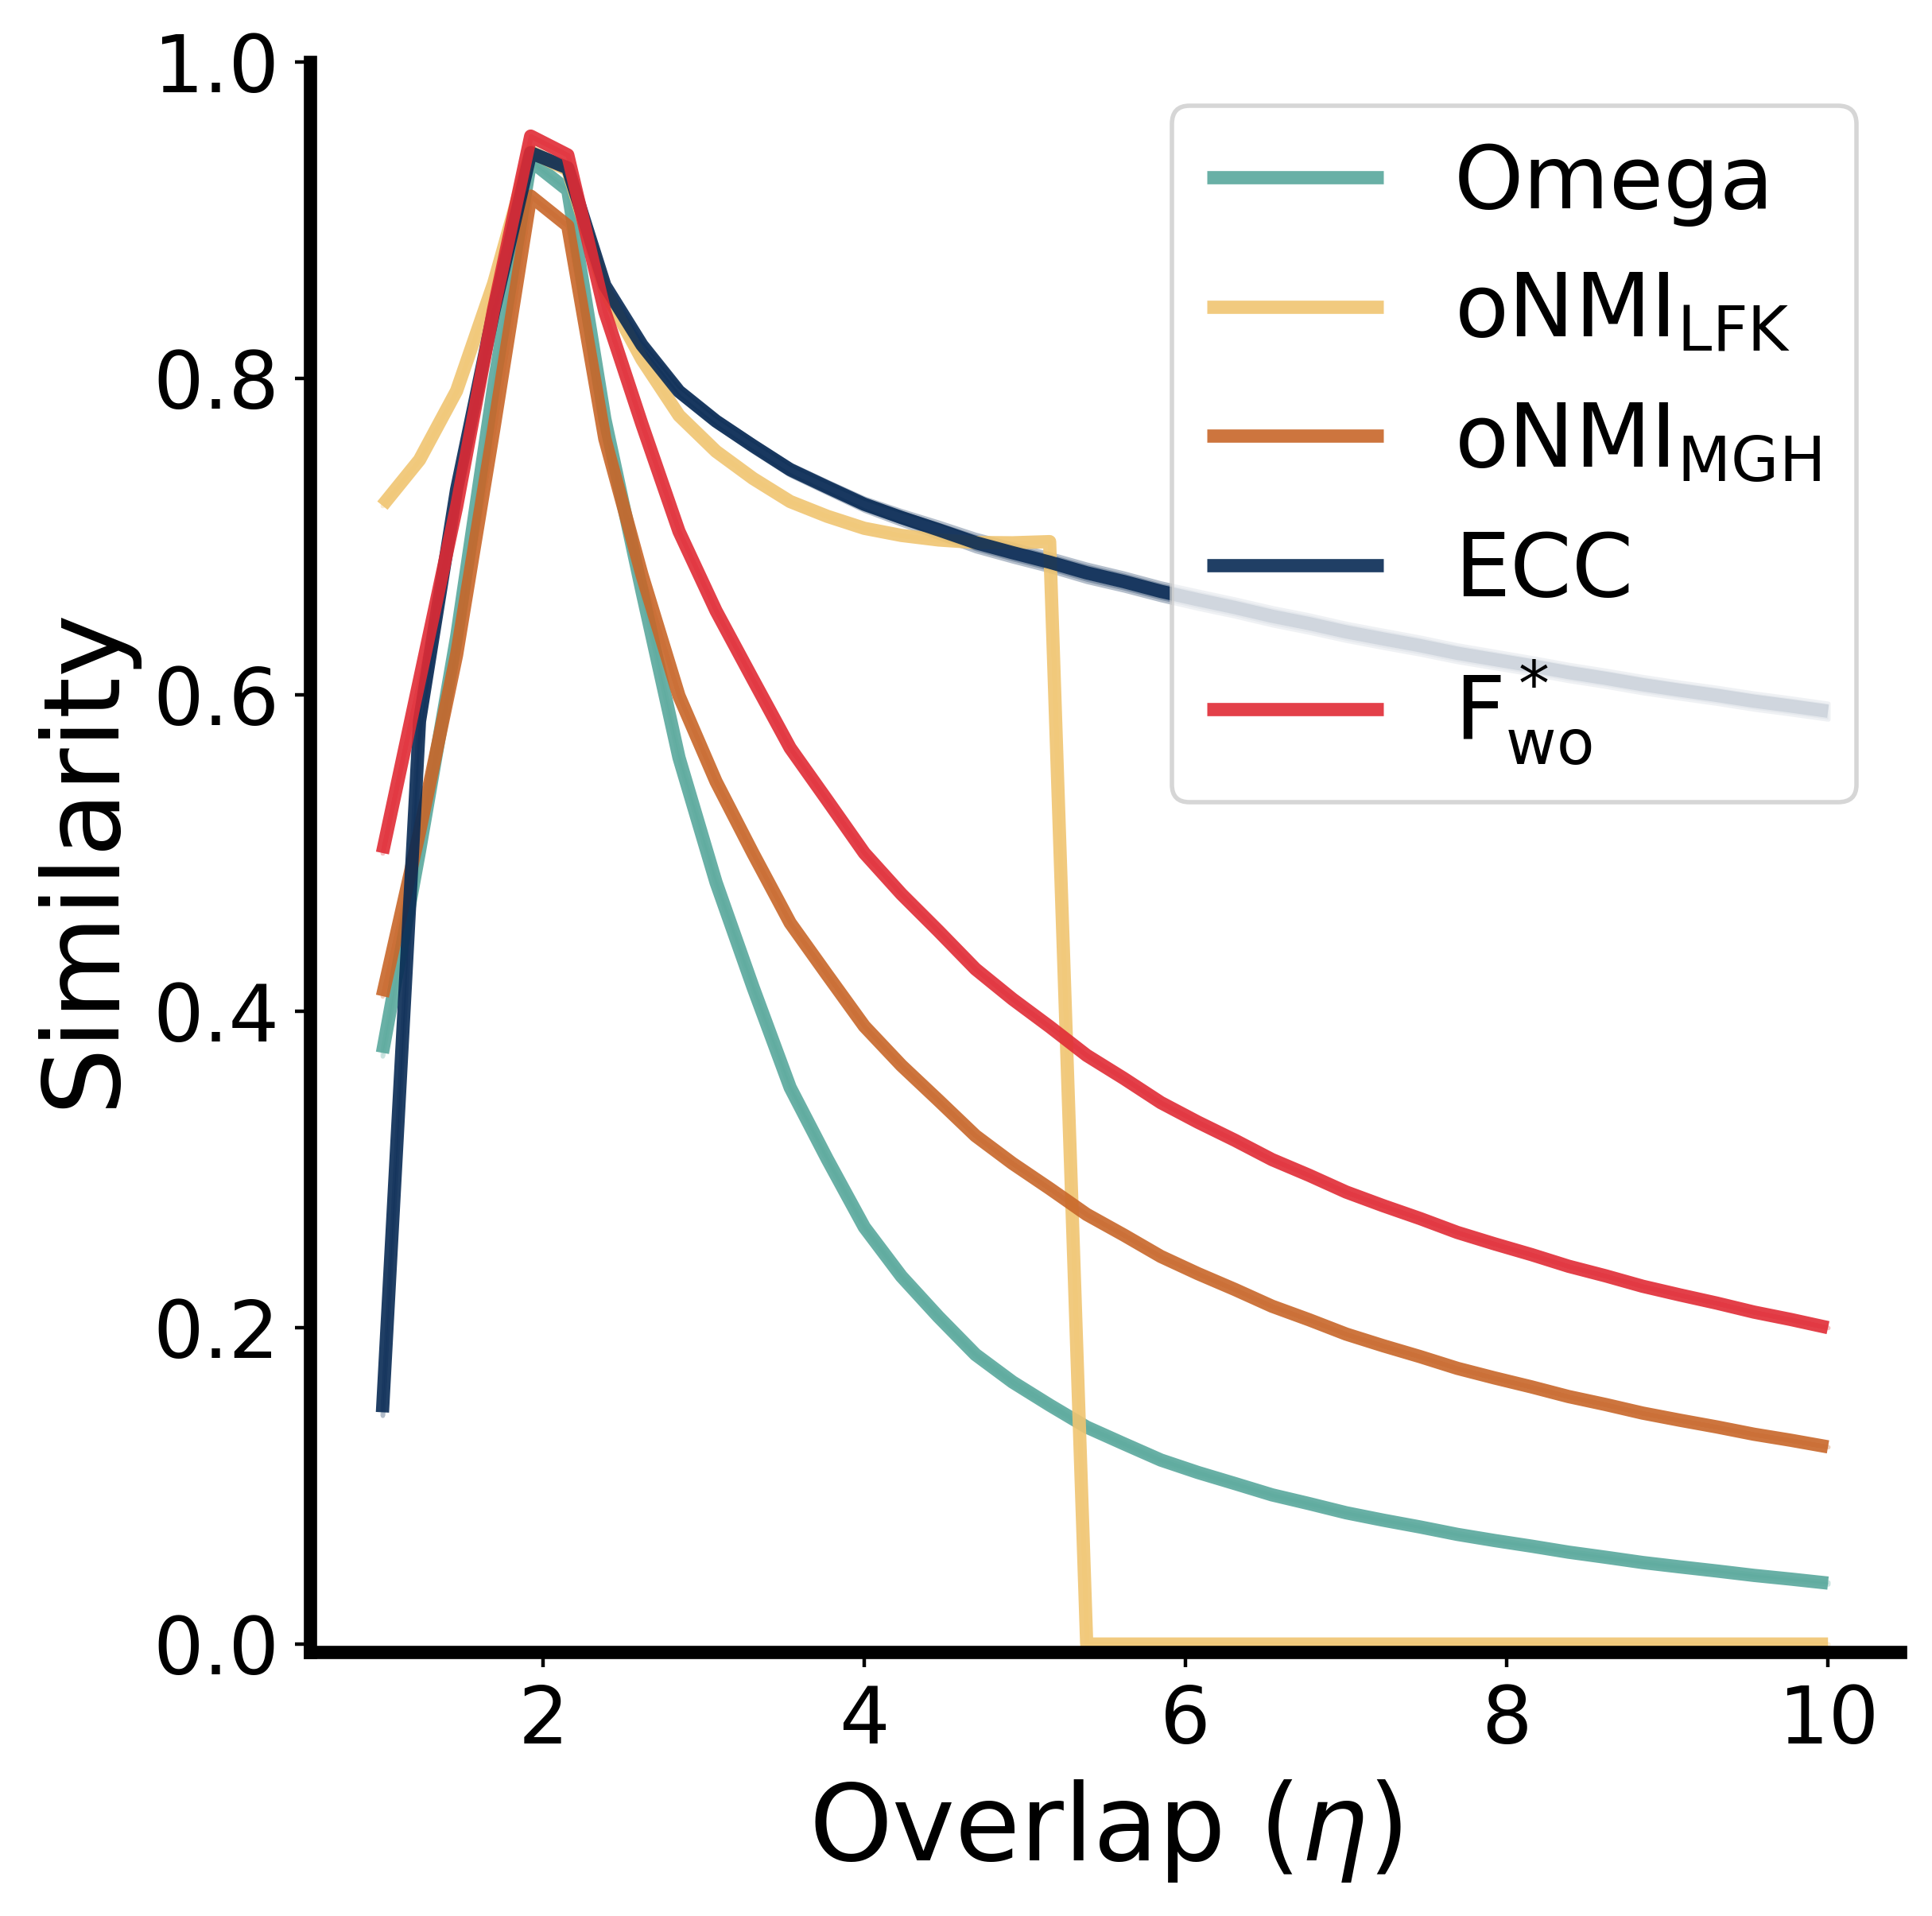

In [15]:
# plot results
overlap_measure_mean = np.load("overlap_mean.npy")
overlap_measure_stds = np.load("overlap_std.npy")

fig, ax = plt.subplots(1,1, figsize = (6,6), dpi=400)

for imeasure in range(n_measures):
    line = ax.plot(etas, overlap_measure_mean[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 3, dashes = [500,1])

for imeasure in range(n_measures):
    ax.fill_between(etas, overlap_measure_mean[imeasure] - overlap_measure_stds[imeasure], 
                    overlap_measure_mean[imeasure] + overlap_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)

ax.set_ylim([-0.005, 1])
#ax.set_xlim([6, 1032])

#ax.set_xticks([10, 100, 1000], [10, 100, 1000])
#ax.set_yticks([0.0, 0.1, 0.2])
ax.tick_params(labelsize=18)

ax.set_xlabel(r'Overlap ($\eta$)', fontsize=24)
ax.set_ylabel('Similarity', fontsize=24)  

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(3)

ax.legend(labels=measure_name, fontsize=20)
set_size(5,5)
plt.show()

In [16]:
def shrink_communities(geom_layer, primary_community, eta):
    overlapping_coms = sp.lil_matrix((np.max(primary_community)+1, n_elements), dtype="bool")
    ids = np.arange(len(primary_community))
    for com in range(np.max(primary_community)+1):
        n_to_keep = int(np.sum(primary_community == com) * (1-eta))
        center = np.mean(geom_layer[primary_community == com, :], axis=0)
        this_com = geom_layer[primary_community == com]
        original_ids = ids[primary_community == com]
        distances_to_center = np.sqrt(np.sum((this_com - center)**2, axis=1))
        keep_ids = np.argsort(distances_to_center)[:n_to_keep]
        new_original_ids = original_ids[keep_ids]
        overlapping_coms[com, new_original_ids] = True
    return overlapping_coms.tocsr()

In [17]:
base_eta = 0.5
n_etas = 30
rng = np.random.default_rng(seed=42)

etas = np.linspace(0, 0.95, n_etas)
outlier_compare = np.zeros((n_measures, len(etas), n_samples))

community_sizes = [n_elements // n_clusterfixed] *  n_clusterfixed

with tqdm(total=len(etas)*n_samples) as pbar:
    for isample in range(n_samples):
        geom_layer, primary_com = sample_geom_and_primary_com(n_elements, community_sizes, rng)
        c1 = shrink_communities(geom_layer, primary_com, base_eta)
        initial_cluster = sparse_to_clustering(c1)
        for j, eta in enumerate(etas):
            c2 = shrink_communities(geom_layer, primary_com, eta)
            random_cluster = sparse_to_clustering(c2)
            for imeasure in range(n_measures):
                if measure_list[imeasure] in ['oNMI', "fstar"]:
                    outlier_compare[imeasure, j, isample] = eval(measure_list[imeasure]+'(c1, c2)')
                elif measure_list[imeasure] in ['elmsim']:
                    outlier_compare[imeasure, j, isample] = eval(measure_list[imeasure]+'(initial_cluster, random_cluster)')
            pbar.update()

outlier_measure_mean = np.mean(outlier_compare, axis = 2)
outlier_measure_stds = np.std(outlier_compare, axis = 2)

np.save("outlier_mean.npy", outlier_measure_mean)
np.save("outlier_std.npy", outlier_measure_stds)
print("Simulation Finished")

100%|██████████| 750/750 [00:34<00:00, 21.78it/s]

Simulation Finished


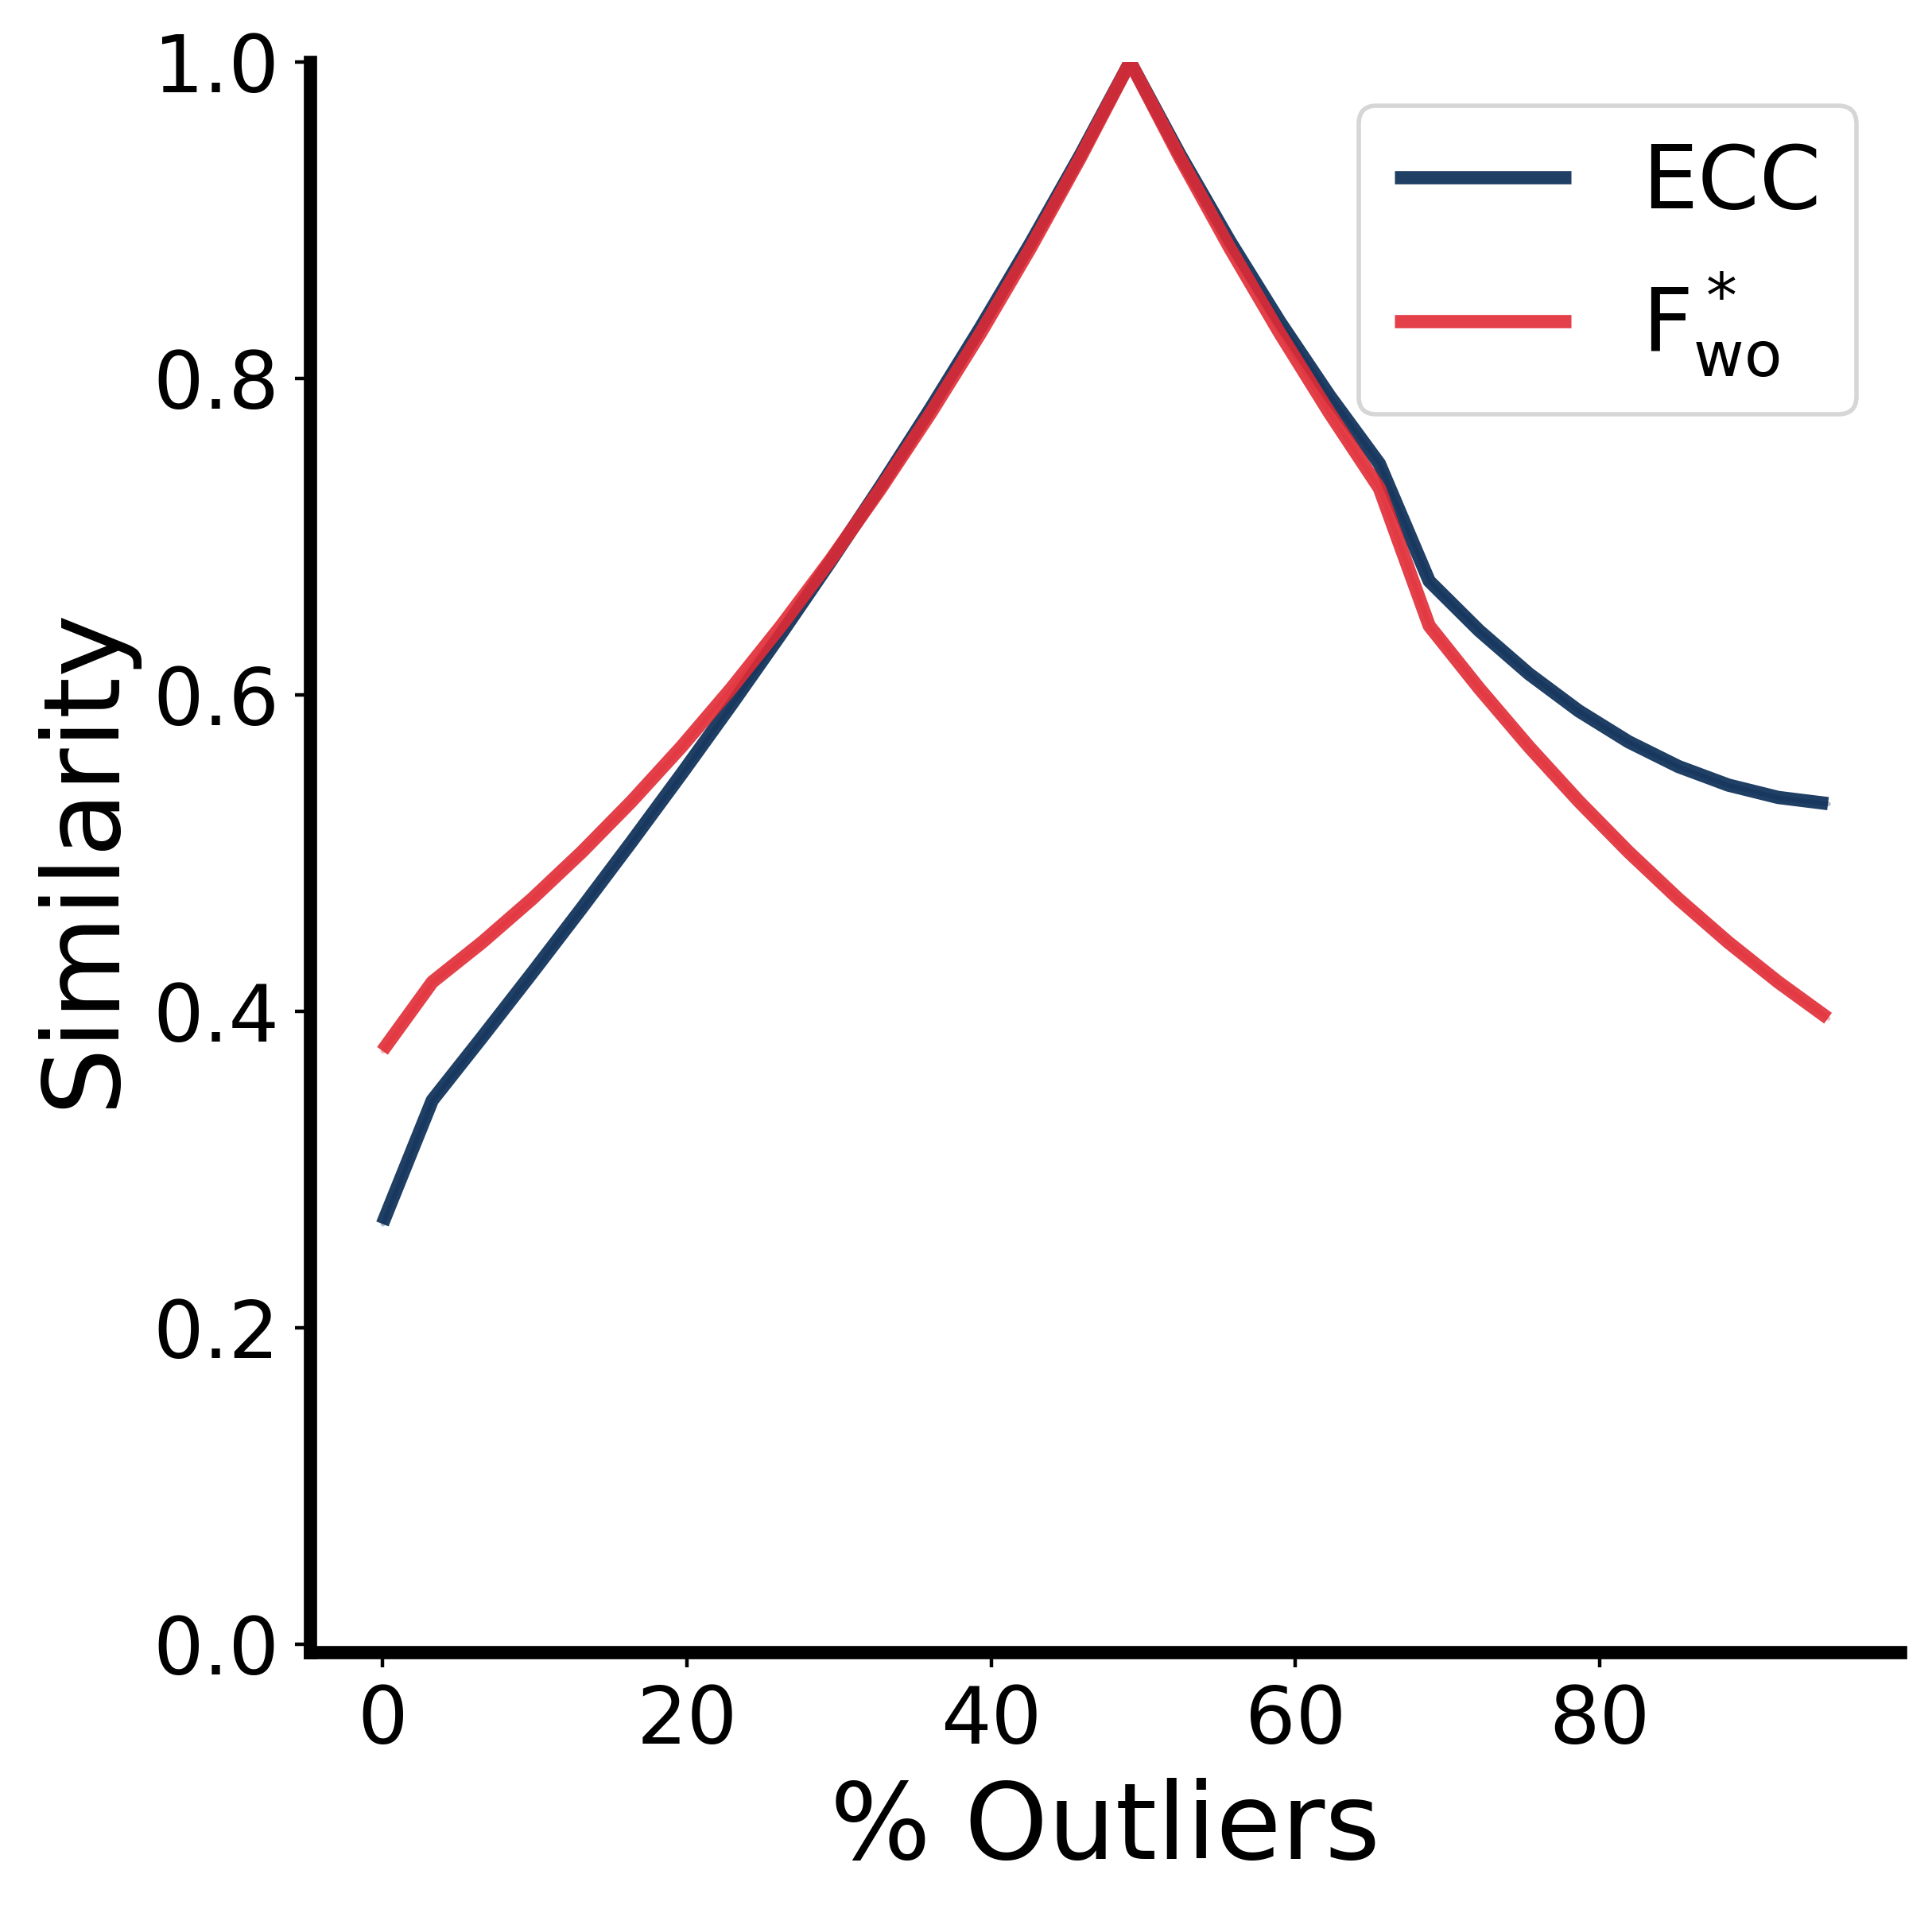

In [18]:
# plot results
outlier_measure_mean = np.load("outlier_mean.npy")
outlier_measure_stds = np.load("outlier_std.npy")

fig, ax = plt.subplots(1,1, figsize = (6,6), dpi=400)

for imeasure in range(n_measures):
    if imeasure not in [3,4]:
        continue
    line = ax.plot(etas*100, outlier_measure_mean[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 3, dashes = [500,1])

for imeasure in range(n_measures):
    if imeasure not in [3,4]:
        continue
    ax.fill_between(etas*100, outlier_measure_mean[imeasure] - outlier_measure_stds[imeasure], 
                    outlier_measure_mean[imeasure] + outlier_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)

ax.set_ylim([-0.005, 1])
ax.tick_params(labelsize=18)

ax.set_xlabel(r'% Outliers', fontsize=24)
ax.set_ylabel('Similarity', fontsize=24)  

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(3)

ax.legend(labels=measure_name[3:], fontsize=20)
set_size(5,5)
plt.show()

# Fig1 (2nd and 3 rows)

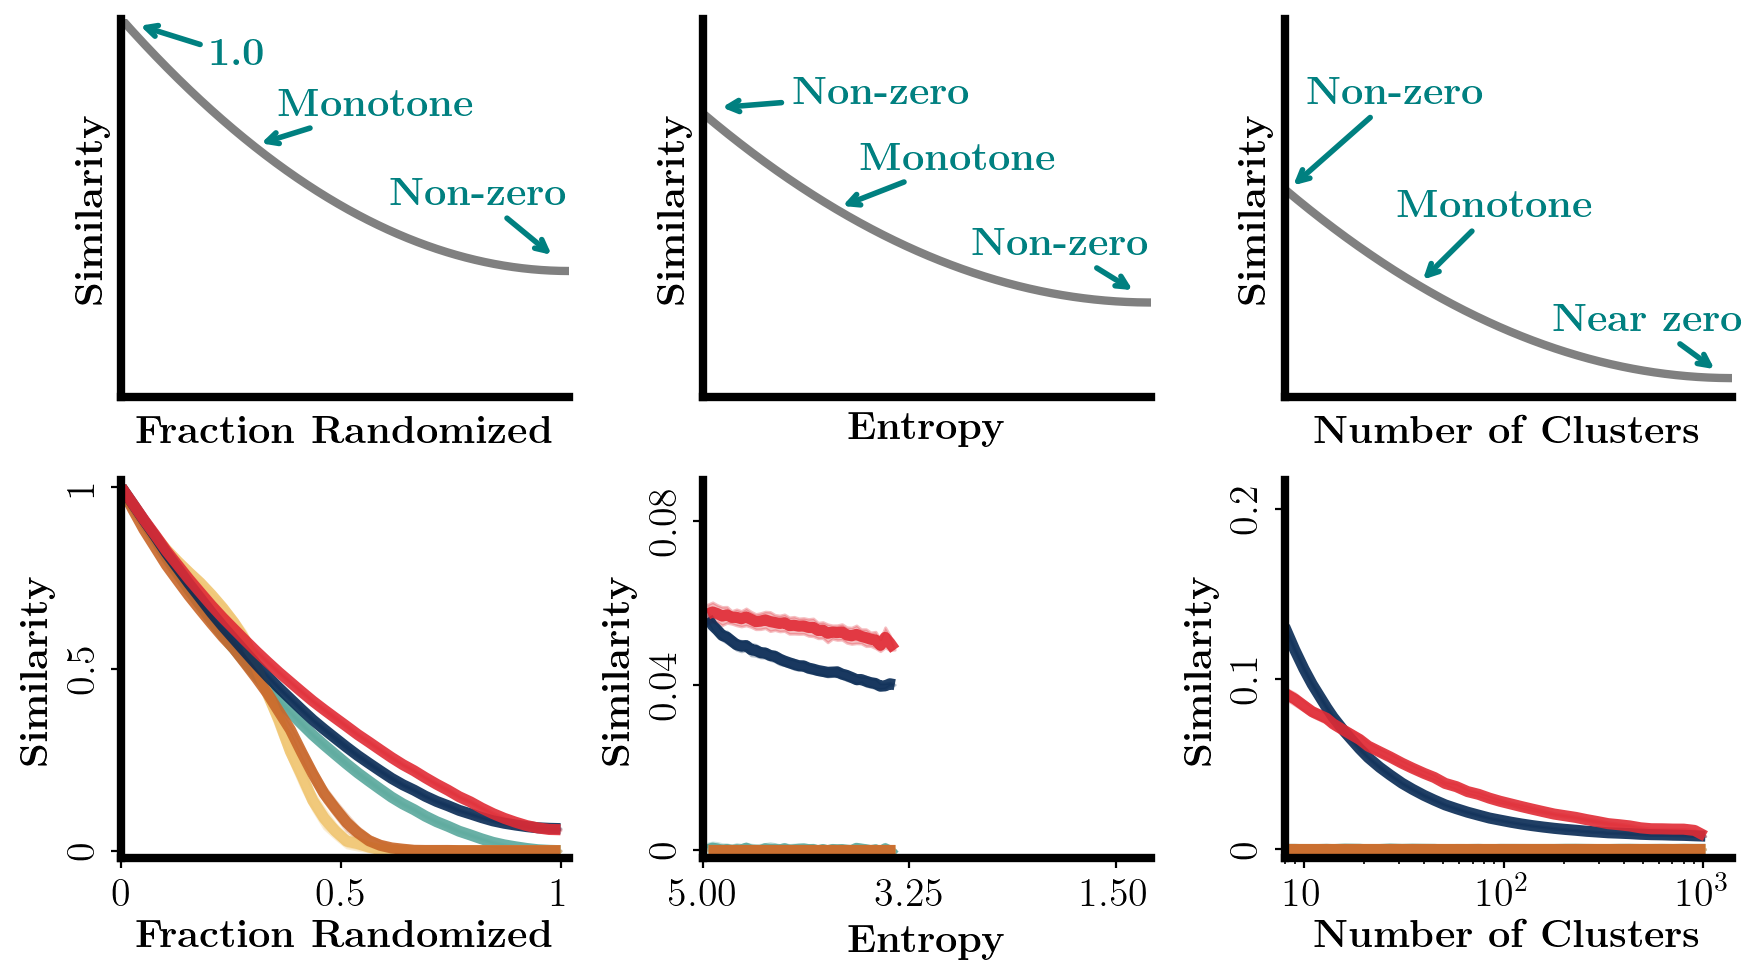

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(9,5), dpi=200)

n_shuffle_points = 40

percent_shuffle_values = np.linspace(0.0, 1.0, n_shuffle_points)
percent_randomize_compare = np.zeros((n_measures, n_shuffle_points, n_samples))
# plot results
measure_means = np.load("random_means.npy")
measure_stds = np.load("random_stds.npy")

for imeasure in range(n_measures):
    line = axs[1,0].plot(percent_shuffle_values, measure_means[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 4, dashes = [500,1])    
for imeasure in range(n_measures):
    axs[1,0].fill_between(percent_shuffle_values, measure_means[imeasure] - measure_stds[imeasure], 
                measure_means[imeasure] + measure_stds[imeasure], 
                        color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)
axs[1,0].set_xlim([0,1.02])
axs[1,0].set_ylim([-0.02, 1.02])
axs[1,0].set_xticks([0.0, 0.5, 1.0], [0, 0.5, 1])
axs[1,0].set_yticks([0.0, 0.5, 1], [0, 0.5, 1], rotation=90, va="center")
#plt.yticks(rotation=90, va="center")
axs[1,0].tick_params(labelsize=14.4)
axs[1,0].set_xlabel(r'\Large\bf Fraction Randomized')
axs[1,0].set_ylabel(r'\Large \bf Similarity')
for spine in ['right', 'top']:
    axs[1,0].spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    axs[1,0].spines[spine].set_linewidth(3)


n_skew_points = 10**2 # increase to 10**4 to increase the entropy range as in the paper
skew_step_size = 5*10**2
n_bins = 40
# plot results
entropy_bins = np.load("entropy_bins.npy")
skew_measure_means = np.load("skew_means.npy")
skew_measure_stds = np.load("skew_stds.npy")

for imeasure in range(n_measures):
    line = axs[1,1].plot(entropy_bins[:-1], skew_measure_means[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 4, dashes = [500,1])
for imeasure in range(n_measures):
    axs[1,1].fill_between(entropy_bins[:-1], skew_measure_means[imeasure] - skew_measure_stds[imeasure], 
                    skew_measure_means[imeasure] + skew_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)
axs[1,1].set_ylim([-0.002, 0.09])
axs[1,1].set_xlim([5, 1.2])
axs[1,1].set_xticks([5.,3.25, 1.5])
axs[1,1].set_yticks([0, 0.04, 0.08], [0, 0.04, 0.08], rotation=90, va="center")
axs[1,1].tick_params(labelsize=14.4)
axs[1,1].set_xlabel(r'\Large \bf Entropy')
axs[1,1].set_ylabel(r'\Large \bf Similarity')
for spine in ['right', 'top']:
    axs[1,1].spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    axs[1,1].spines[spine].set_linewidth(3)


min_clusters = 2**3
n_cluster_points = 40
number_cluster_values = np.logspace(np.log2(min_clusters), np.log2(n_elements), n_cluster_points, base = 2, dtype = int)
# plot results
numc_measure_mean = np.load("numc_mean.npy")
numc_measure_stds = np.load("numc_std.npy")
for imeasure in range(n_measures):
    line = axs[1,2].plot(number_cluster_values, numc_measure_mean[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 4, dashes = [500,1])
for imeasure in range(n_measures):
    axs[1,2].fill_between(number_cluster_values, numc_measure_mean[imeasure] - numc_measure_stds[imeasure], 
                    numc_measure_mean[imeasure] + numc_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)
axs[1,2].set_xscale('log')
axs[1,2].set_ylim([-0.005, 0.217])
axs[1,2].set_xlim([8, 1400])
axs[1,2].set_xticks([10, 100, 1000], [r"$10$", r"$10^2$", r"$10^3$"])
axs[1,2].set_yticks([0.0, 0.1, 0.2], [0, 0.1, 0.2], rotation=90, va="center")
axs[1,2].tick_params(labelsize=14.4)
axs[1,2].set_xlabel(r'\Large \bf Number of Clusters')
axs[1,2].set_ylabel(r'\Large \bf Similarity')    
for spine in ['right', 'top']:
    axs[1,2].spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    axs[1,2].spines[spine].set_linewidth(3)


###################
# Intuition Plots #
###################
for ax in (axs[0,0], axs[0,1], axs[0,2]):
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(3)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

xs = np.linspace(0,1, 1000)
ys00 = (1-xs)**2 + 0.5
axs[0,0].plot(xs, ys00, linewidth=3, color="gray")
axs[0,0].set_ylim([0,1.5])
axs[0,0].set_xlim([0,1])

axs[0,0].annotate(r"\Large \bf 1.0", (0.03,1.48), xytext=(0.2,1.35), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,0].annotate(r"\Large \bf Monotone", (0.3,1), xytext=(0.35,1.15), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,0].annotate(r"\Large \bf Non-zero", (0.97,0.55), xytext=(0.6,0.8), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,0].set_xlabel(r'\Large\bf Fraction Randomized', labelpad=8)
axs[0,0].set_ylabel(r'\Large \bf Similarity')


ys01 = (1-xs)**2 + 0.5
axs[0,1].plot(xs, ys01, linewidth=3, color="gray")
axs[0,1].set_ylim([0,2])
axs[0,1].set_xlim([0,1])

axs[0,1].annotate(r"\Large \bf Non-zero", (0.03,1.53), xytext=(0.2,1.6), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,1].annotate(r"\Large \bf Monotone", (0.3,1), xytext=(0.35,1.25), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,1].annotate(r"\Large \bf Non-zero", (0.97,0.55), xytext=(0.6,0.8), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,1].set_xlabel(r'\Large \bf Entropy', labelpad=5)
axs[0,1].set_ylabel(r'\Large \bf Similarity')


ys02 = (1-xs)**2 + 0.1
axs[0,2].plot(xs, ys02, linewidth=3, color="gray")
axs[0,2].set_ylim([0,2])
axs[0,2].set_xlim([0,1])

axs[0,2].annotate(r"\Large \bf Non-zero", (0.01,1.1), xytext=(0.05,1.6), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,2].annotate(r"\Large \bf Monotone", (0.3,0.6), xytext=(0.25,1), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,2].annotate(r"\Large \bf Near zero", (0.97,0.13), xytext=(0.6,0.4), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,2].set_xlabel(r'\Large \bf Number of Clusters', labelpad=8)
axs[0,2].set_ylabel(r'\Large \bf Similarity')  

plt.tight_layout()
plt.savefig("fig1_alt.pdf")

# Fig 2 (Second and third columns)

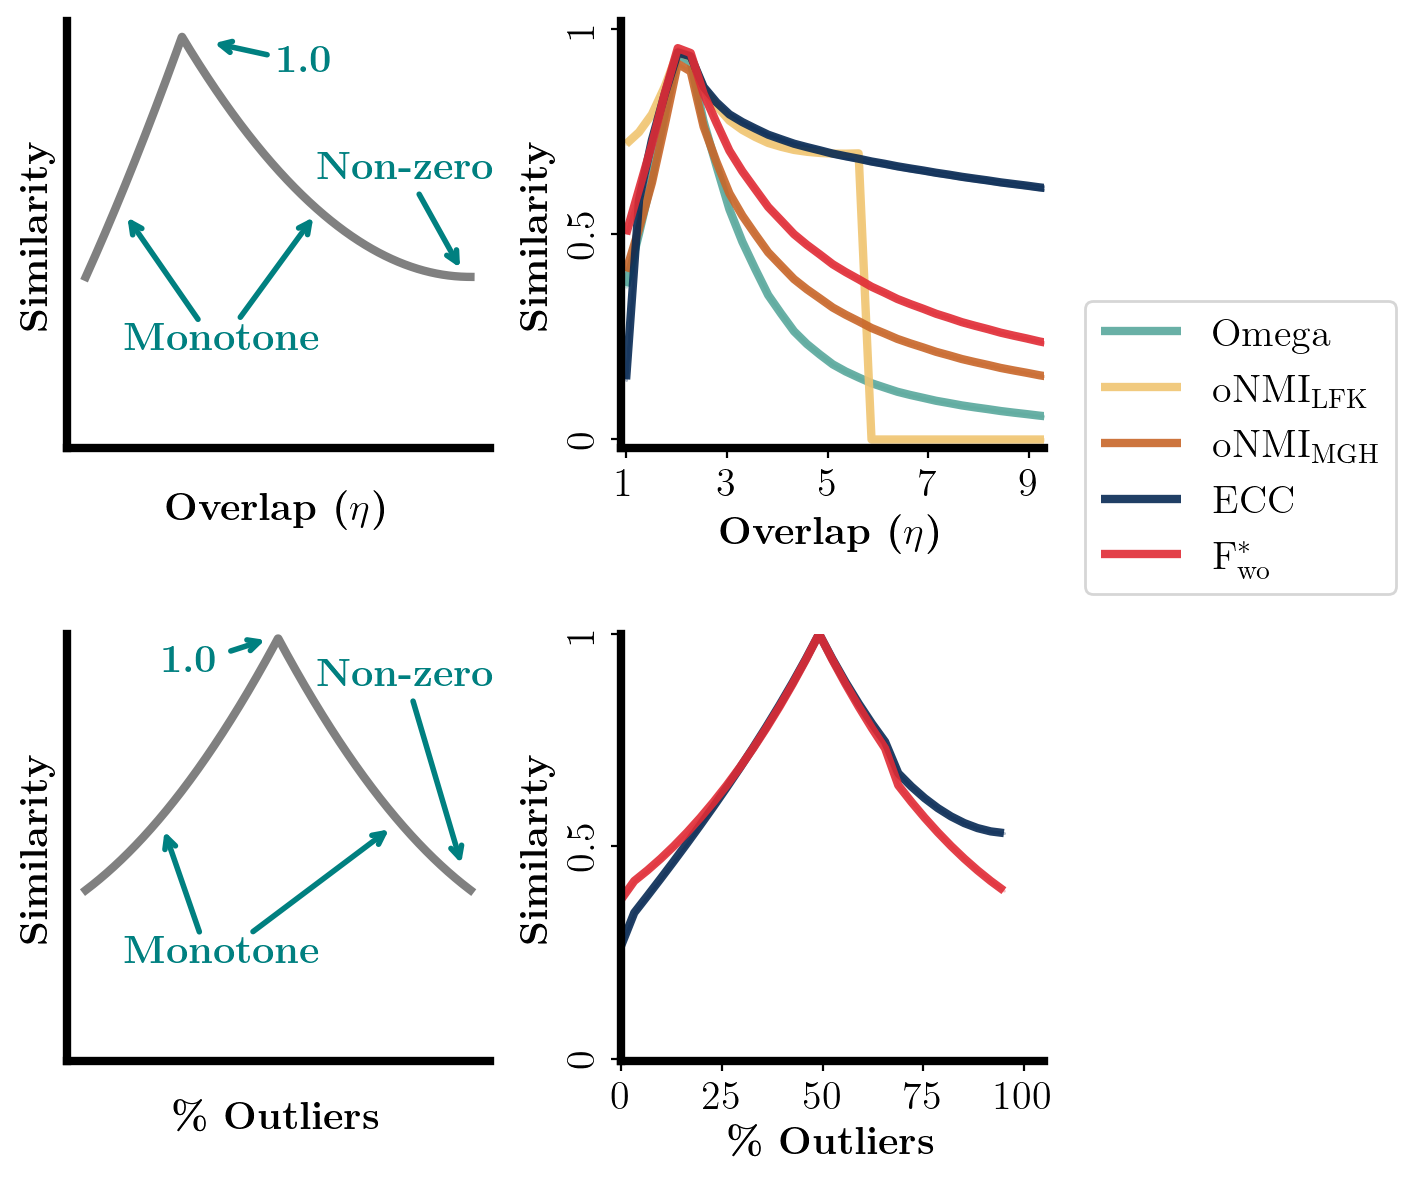

In [33]:
fig, axs =  plt.subplots(2,2, figsize=(7.2,6), dpi=200)

base_eta = 3
n_etas = 40
etas = np.linspace(1, 11, n_etas)
# plot results
overlap_measure_mean = np.load("overlap_mean.npy")
overlap_measure_stds = np.load("overlap_std.npy")

for imeasure in range(n_measures):
    line = axs[0,1].plot(etas, overlap_measure_mean[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 3, dashes = [500,1])
for imeasure in range(n_measures):
    axs[0,1].fill_between(etas, overlap_measure_mean[imeasure] - overlap_measure_stds[imeasure], 
                    overlap_measure_mean[imeasure] + overlap_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)
axs[0,1].set_ylim([-0.02, 1.02])
axs[0,1].set_yticks([0, 0.5, 1], [0, 0.5, 1], rotation=90, va="center")
axs[0,1].set_xlim([0.9, 9.3])
axs[0,1].set_xticks([1, 3, 5, 7, 9])
axs[0,1].set_xlabel(r'\Large \bf Overlap ($\eta$)')
axs[0,1].set_ylabel(r'\Large \bf Similarity')
axs[0,1].tick_params(labelsize=14.4)
for spine in ['right', 'top']:
    axs[0,1].spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    axs[0,1].spines[spine].set_linewidth(3)
axs[0,1].legend(labels=measure_name, loc='center left', bbox_to_anchor=(1.05, 0), fontsize=14.4)

base_eta = 0.5
n_etas = 30
etas = np.linspace(0, 0.95, n_etas)
# plot results
outlier_measure_mean = np.load("outlier_mean.npy")
outlier_measure_stds = np.load("outlier_std.npy")

for imeasure in range(n_measures):
    if imeasure not in [3,4]:
        continue
    line = axs[1,1].plot(etas*100, outlier_measure_mean[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 3, dashes = [500,1])
for imeasure in range(n_measures):
    if imeasure not in [3,4]:
        continue
    axs[1,1].fill_between(etas*100, outlier_measure_mean[imeasure] - outlier_measure_stds[imeasure], 
                    outlier_measure_mean[imeasure] + outlier_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)
axs[1,1].set_ylim([-0.005, 1])
axs[1,1].set_yticks([0, 0.5, 1], [0, 0.5, 1], rotation=90, va="center")
axs[1,1].set_xticks([0,25,50,75,100])
axs[1,1].set_xlim([0, 105])
axs[1,1].tick_params(labelsize=14.4)
axs[1,1].set_xlabel(r'\Large \bf \% Outliers')
axs[1,1].set_ylabel(r'\Large \bf Similarity')  
for spine in ['right', 'top']:
    axs[1,1].spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    axs[1,1].spines[spine].set_linewidth(3)


###################
# Intuition Plots #
###################
for ax in (axs[0,0], axs[1,0]):
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(3)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

xs = np.linspace(0, 1, 1000)

y00 = np.zeros_like(xs)
max_arg = int(len(xs) / 4)
y00[:max_arg] = xs[:max_arg] **2 + 2*xs[:max_arg] + 0.4
y00[max_arg:] = (1-xs[max_arg:])**2 + 0.4
axs[0,0].plot(xs, y00, lw=3, color="gray")
axs[0,0].set_ylim([0,1])
axs[0,0].annotate(r"\Large \bf 1.0", (0.32,0.95), xytext=(0.5,0.9), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,0].annotate(r"\Large \bf Monotone", (0.6,0.55), xytext=(0.1,0.25), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,0].annotate("", (0.1, 0.55), xytext=(0.3, 0.29), arrowprops=dict(color="teal", arrowstyle="->", lw=2))
axs[0,0].annotate(r"\Large \bf Non-zero", (0.98,0.41), xytext=(0.6,0.65), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[0,0].set_xlabel("\n" + r'\Large \bf Overlap ($\eta$)')
axs[0,0].set_ylabel(r'\Large \bf Similarity')

y10 = np.zeros_like(xs)
max_arg = int(len(xs) / 2)
y10[:max_arg] = xs[:max_arg] **2 + 0.68*xs[:max_arg] + 0.4
y10[max_arg:] = (1-xs[max_arg:])**2 + 0.68*(1-xs[max_arg:])+ 0.4
axs[1,0].plot(xs, y10, lw=3, color="gray")
axs[1,0].set_ylim([0,1])
axs[1,0].annotate(r"\Large \bf 1.0", (0.48,0.99), xytext=(0.2,0.93), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[1,0].annotate(r"\Large \bf Monotone", (0.8,0.55), xytext=(0.1,0.25), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[1,0].annotate("", (0.2, 0.55), xytext=(0.3, 0.29), arrowprops=dict(color="teal", arrowstyle="->", lw=2))
axs[1,0].annotate(r"\Large \bf Non-zero", (0.98,0.45), xytext=(0.6,0.9), va="center", color="teal", arrowprops=dict(color="teal", lw=2, arrowstyle="->"))
axs[1,0].set_xlabel("\n" + r'\Large \bf \% Outliers')
axs[1,0].set_ylabel(r'\Large \bf Similarity')

plt.tight_layout()
plt.savefig("fig2_alt.pdf")